In [1]:
from astropy.table import Table
import numpy as np
from ltsfit.ltsfit import ltsfit
from matplotlib import pyplot as plt
import corner
from utils import fit_plane, find_scatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# load the GGL data tables with different sky areas of lenses but galaxy population is on 100 deg^2
sky_area = "1000.0"
# GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG_new.fits", format='fits')


# GGL_data_table


GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG_NON_SIS.fits", format='fits')

contrast_mask = np.zeros(len(GGL_data_table), dtype=bool)
# ps_magnification_mask = np.zeros(len(GGL_data_table), dtype=bool)
for i in range(len(GGL_data_table)):
    
    # contrast mask
    all_vals = GGL_data_table['contrast_ratio_i'][i]
    all_vals = all_vals[~np.isnan(all_vals)]
    # get linear scale values
    all_vals = 10**(-0.4 * all_vals)
    contrast_mask[i] = np.all(all_vals > 2) # all images should have contrast ratio > 2

    # point source magnification mask
    # ps_magnifications = GGL_data_table['ps_magnification'][i]
    # ps_magnifications = ps_magnifications[~np.isnan(ps_magnifications)]
    # high_mag = np.any(np.abs(ps_magnifications) > 3)
    # ps_magnification_mask[i] = high_mag

# add a column for r_band lensed source magnitude
GGL_data_table['mag_S_r_lensed'] = GGL_data_table['mag_S_r'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))
GGL_data_table['mag_S_i_lensed'] = GGL_data_table['mag_S_i'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))

GGL_data_table = GGL_data_table[ 
                                #  (GGL_data_table['mag_D_i'] >= 19) 
                                (GGL_data_table['mag_S_i_lensed'] < 28)
                                & (GGL_data_table['mag_D_i'] < 28)
                                & (contrast_mask)
                                & (np.abs(GGL_data_table['es_magnification']) > 3)
                                # & (ps_magnification_mask)
                                ]

GGL_data_table

<Table length=15987>
lens_id        z_D         ...   mag_S_r_lensed     mag_S_i_lensed  
 int64       float64       ...      float64            float64      
------- ------------------ ... ------------------ ------------------
      0 1.4100545160514653 ...  24.15035581054937  23.91250376426658
      1  1.512036472199786 ... 24.534119314017765 24.416983705203236
      3 1.3797860102766537 ... 24.280846694432505 24.267506235456345
      4 0.9793203674576667 ... 24.011932533684487 23.805047391322105
      5 0.6815442845076662 ...  21.34938970679782 21.069562936672956
      6 1.5257562380230418 ... 24.274843340220055 24.158192241383748
      8 1.0324273124661707 ... 24.801705078917998  24.45903202693207
      9 0.7954816615230628 ... 24.232014763293545 24.126720610971137
     10 1.0777004207741332 ...  21.41094883275644  21.26941242784644
    ...                ... ...                ...                ...
  29694 0.7973260127575952 ...  23.47830333050787 23.417363438196077
  29695 1.3937259888490465 ...  23.20387345061555  23.10236424024446
  29697  0.403028235790644 ... 24.285480923615722 24.074661077911223
  29698 0.6345534618124111 ... 24.218460399440417 23.431370011932344
  29699 0.6265117135448391 ...  24.92868448114087  24.66514179801822
  29700  0.698650082467901 ... 24.581197306671207 24.516907397294027
  29701 1.6830574101127422 ...  24.03721883847524  23.82205385922716
  29703 0.8330528734245778 ...  24.22985178546996  24.04438526911305
  29704 1.1176306371706077 ... 24.032337533404707 24.039509408409764
  29705 1.0313899705078013 ... 22.706006082167757 22.644664263971077

In [4]:
# single exposure
# point source depths: g < 26.0, r < 25.7, i < 25.0, z < 24.3, y < 23.1
# extended source depths are 1 mag shallower: g < 25.0, r < 24.7, i < 24.0, z < 23.3, y < 22.1
lsst_1_yr_coadd_mag_depth_mask = (
                        (GGL_data_table['mag_D_i'] < 24.0)
                        & (GGL_data_table['mag_S_i_lensed'] < 24.0)
)

# 10 year coadd
# point source depths: g < 27.4, r < 27.5, i < 26.8, z < 26.1, y < 24.9
# extended source depths are 1 mag shallower: g < 26.4, r < 26.5, i < 25.8, z < 25.1, y < 23.9
lsst_10_yr_coadd_mag_depth_mask = (
                        (GGL_data_table['mag_D_i'] < 25.8)
                        & (GGL_data_table['mag_S_i_lensed'] < 25.8)
)

# 4MOST spec-z for sources: r < 23.5 and z < 1.5

lsst_4MOST_mag_depth_mask = (
                        # (GGL_data_table['mag_D_r'] < 24.5)
                        (GGL_data_table['mag_S_r_lensed'] < 24)
                        & (GGL_data_table['z_S'] < 1.5) # 4MOST limit
)


lsst_1_yr_GGL_table = GGL_data_table[lsst_1_yr_coadd_mag_depth_mask]
lsst_10_yr_GGL_table = GGL_data_table[lsst_10_yr_coadd_mag_depth_mask]
lsst_4MOST_GGL_table = GGL_data_table[lsst_4MOST_mag_depth_mask]



print('----------------------------------')
print("Sky area:", sky_area, "deg^2")
print('----------------------------------')
print("SLSim (i < 28, contrast_ratio > 2, mu_tot > 3)  # lenses:", len(GGL_data_table))
print("Y1  (i < 24.0)              # lenses:", np.sum(lsst_1_yr_coadd_mag_depth_mask))
print("Y10 (i < 25.8)              # lenses:", np.sum(lsst_10_yr_coadd_mag_depth_mask))
# print("4MOST (z_S < 1.5)                      # lenses:", np.sum(lsst_4MOST_mag_depth_mask))
print("4MOST (r < 24 & z_S < 1.5)  # lenses:", np.sum(lsst_4MOST_mag_depth_mask))
print('----------------------------------')
print()
print('----------------------------------')
print("Sky area:", 20000, "deg^2")
print('----------------------------------')
print("Y1    # lenses:", np.sum(lsst_1_yr_coadd_mag_depth_mask)*20000/float(sky_area))
print("Y10   # lenses:", np.sum(lsst_10_yr_coadd_mag_depth_mask)*20000/float(sky_area))
print("4MOST # lenses:", np.sum(lsst_4MOST_mag_depth_mask)*20000/float(sky_area))
print('----------------------------------')


lsst_1_yr_GGL_table = GGL_data_table[lsst_1_yr_coadd_mag_depth_mask]
lsst_10_yr_GGL_table = GGL_data_table[lsst_10_yr_coadd_mag_depth_mask]
lsst_4MOST_GGL_table = GGL_data_table[lsst_4MOST_mag_depth_mask]

----------------------------------
Sky area: 1000.0 deg^2
----------------------------------
SLSim (i < 28, contrast_ratio > 2, mu_tot > 3)  # lenses: 15987
Y1  (i < 24.0)              # lenses: 9398
Y10 (i < 25.8)              # lenses: 15859
4MOST (r < 24 & z_S < 1.5)  # lenses: 423
----------------------------------

----------------------------------
Sky area: 20000 deg^2
----------------------------------
Y1    # lenses: 187960.0
Y10   # lenses: 317180.0
4MOST # lenses: 8460.0
----------------------------------


SLSim Lenses (1000 deg$^2$) LSST Single Visit Depth sigma_v scatter (MFP): 6.34 %
SLSim Lenses (1000 deg$^2$) LSST Y10-like Depth sigma_v scatter (MFP): 6.25 %
SLSim Lenses (1000 deg$^2$) LSST Y10 + 4MOST-like Depth sigma_v scatter (MFP): 4.8 %


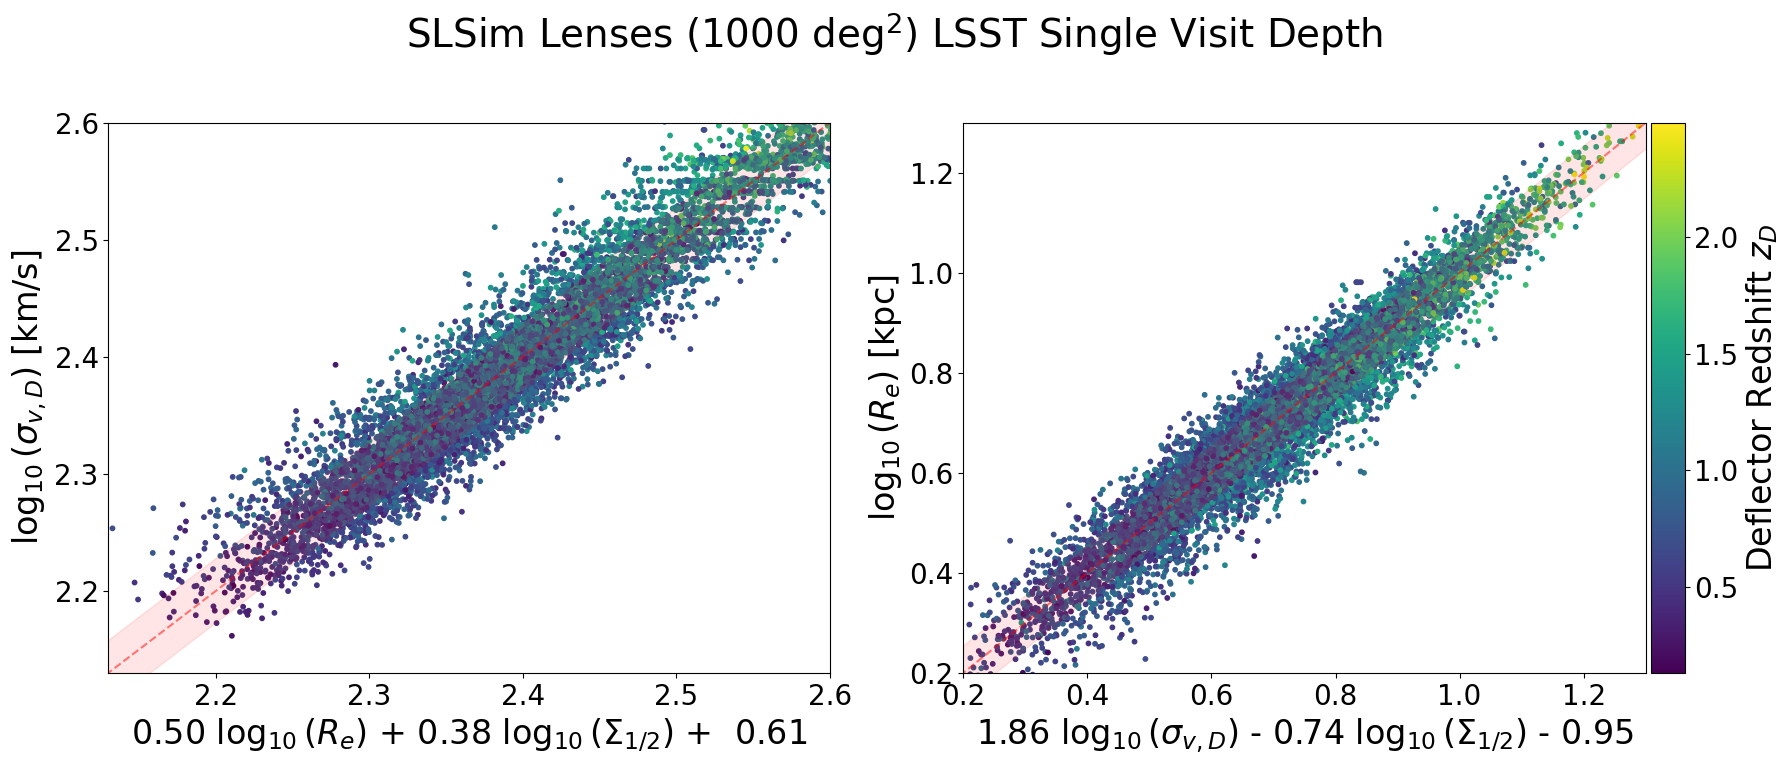

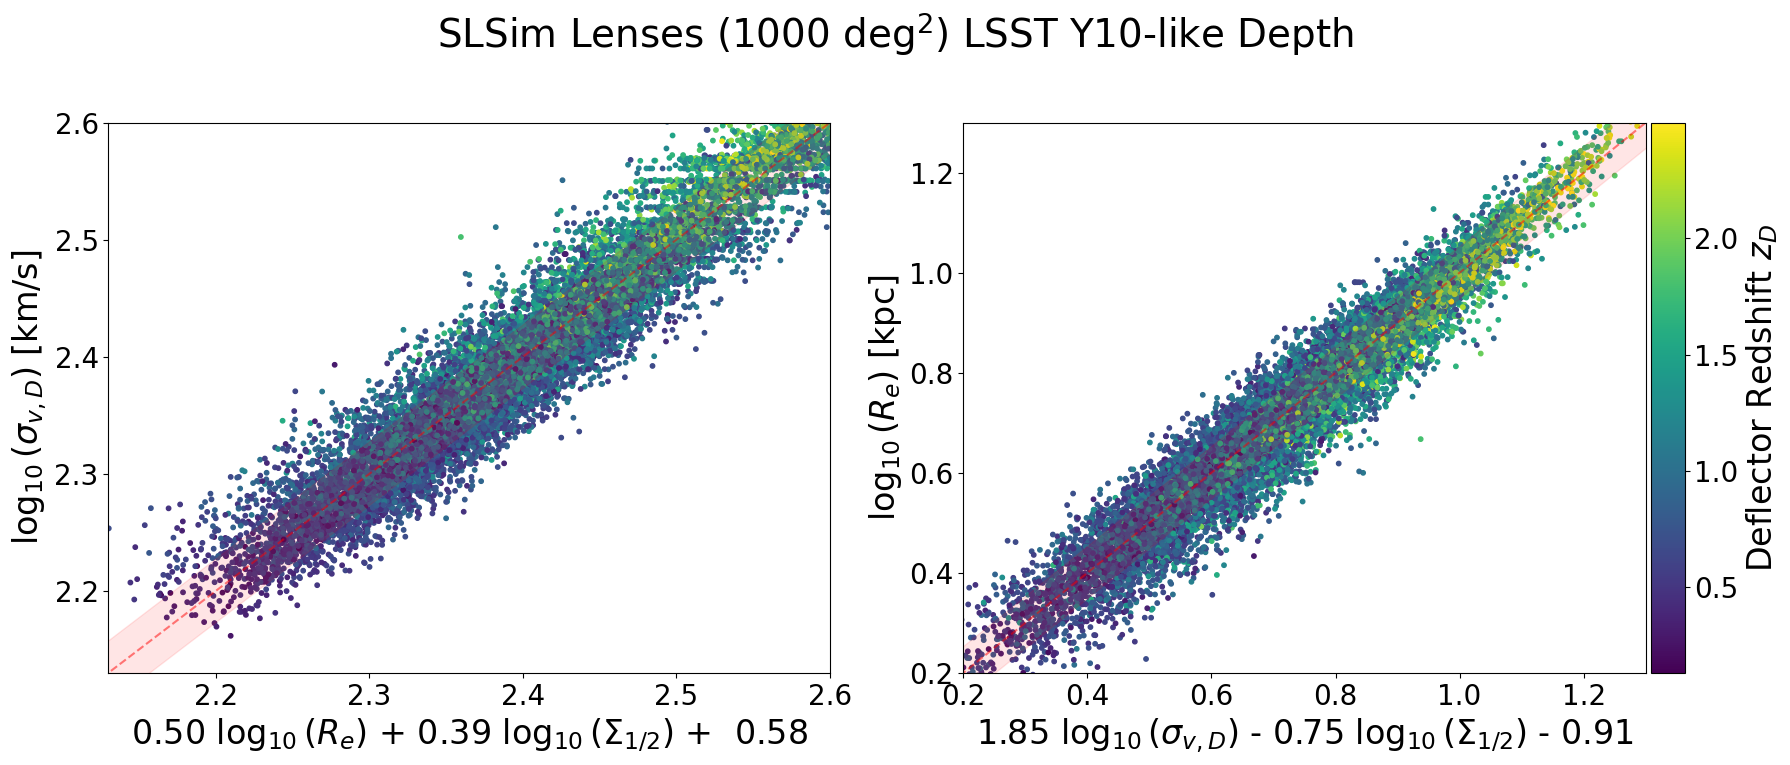

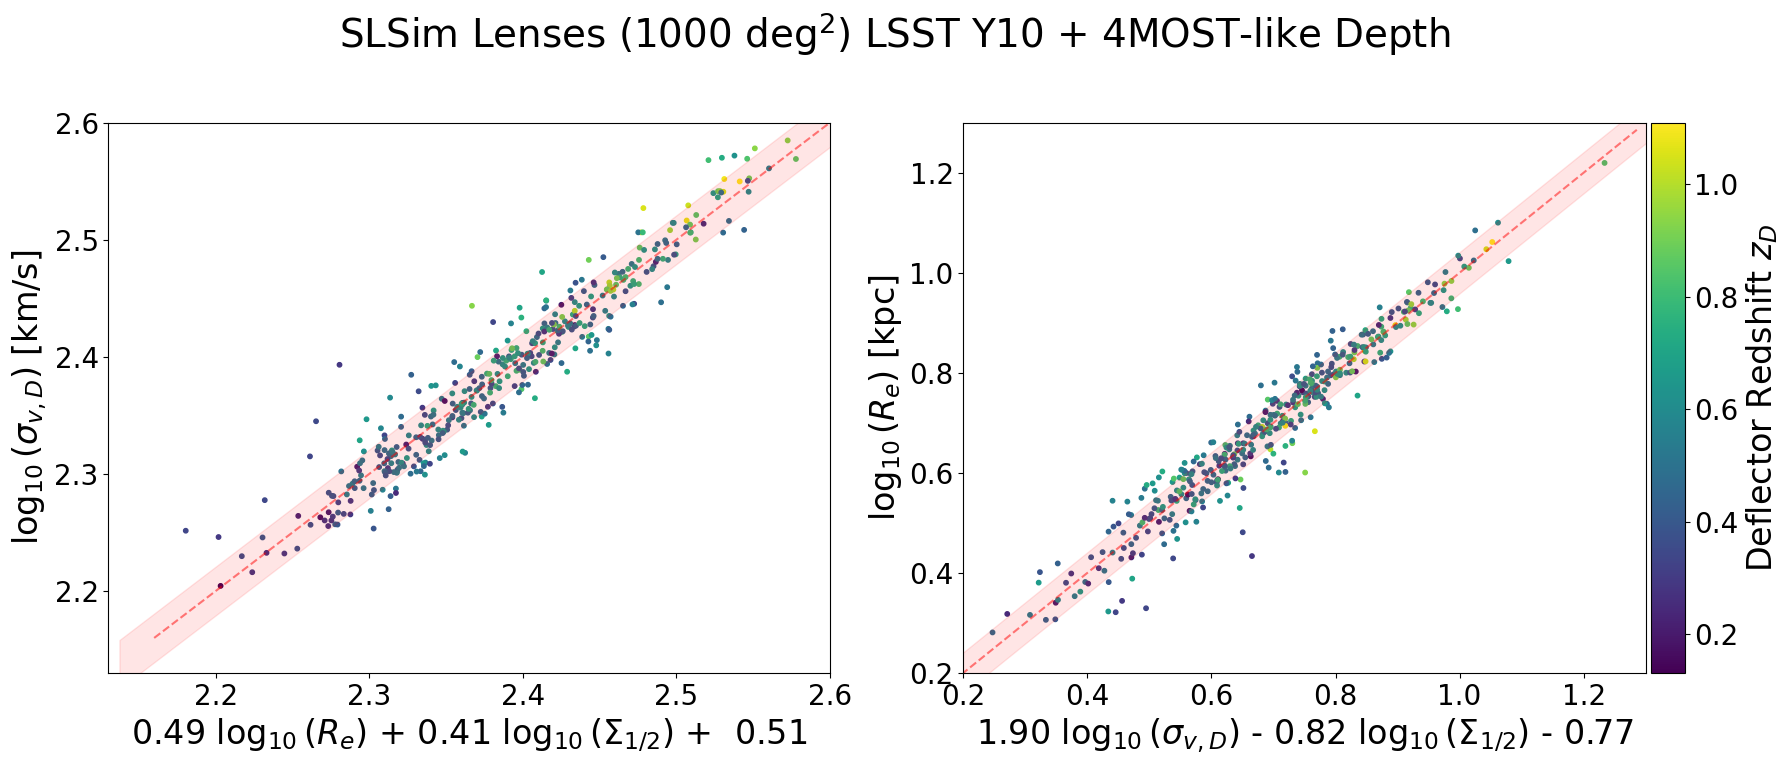

In [5]:
# MFP for the original data at different depths

# title_list = [
#     "SLSim Lenses (1000 deg$^2$) Y1-like Depth",
#     "SLSim Lenses (1000 deg$^2$) Y10-like Depth",
#     "SLSim Lenses (1000 deg$^2$) 4MOST-like Depth",
# ]
title_list = [
    "SLSim Lenses (1000 deg$^2$) LSST Single Visit Depth",
    "SLSim Lenses (1000 deg$^2$) LSST Y10-like Depth",
    "SLSim Lenses (1000 deg$^2$) LSST Y10 + 4MOST-like Depth",
]
i = 0
for data_table in [GGL_data_table[lsst_1_yr_coadd_mag_depth_mask],
                   GGL_data_table[lsst_10_yr_coadd_mag_depth_mask],
                   GGL_data_table[lsst_4MOST_mag_depth_mask]]:
    # fit the MFP
    coeffs_MFP = fit_plane(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"])
    )

    # find the scatter
    scatter_MFP = find_scatter(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"]),
        coeffs_MFP,
        return_fit=False
    )

    # fit the MFP with R_e as the dependent variable
    coeffs_MFP_alt = fit_plane(
        np.log10(data_table["sigma_v_D"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["R_e_kpc"])
    )

    # find the scatter
    scatter_MFP_alt = find_scatter(
        np.log10(data_table["sigma_v_D"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["R_e_kpc"]),
        coeffs_MFP_alt,
        return_fit=False
    )

    # print the scatter in percentage
    print(title_list[i], "sigma_v scatter (MFP):", np.round(np.std(scatter_MFP) * np.log(10) * 100, 2), "%")
    # print(title_list[i], "scatter (MFP alt):", np.std(scatter_MFP_alt) * np.log(10) * 100, "%")

    # side-by-side plot of the two fundamental planes
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # sigma_v fundamental plane
    axs[0].scatter(
        coeffs_MFP[0] * np.log10(data_table["R_e_kpc"]) + 
        coeffs_MFP[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP[2],
        np.log10(data_table["sigma_v_D"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[0].set_xlabel(f'{coeffs_MFP[0]:.2f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_MFP[1]:.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ + ' + f' {coeffs_MFP[2]:.2f}')
    axs[0].set_ylabel(r'$\log_{10}(\sigma_{v, D})$ [km/s]')
    # axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

    # Plot the fitted plane with a faded scatter
    # y = x
    axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
    y_faded = x_faded
    axs[0].fill_between(x_faded, y_faded - np.std(scatter_MFP),
                        y_faded + np.std(scatter_MFP), color='red', alpha=0.1)

    # R_e fundamental plane
    scatter_plot = axs[1].scatter(
        coeffs_MFP_alt[0] * np.log10(data_table["sigma_v_D"]) + 
        coeffs_MFP_alt[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP_alt[2],
        np.log10(data_table["R_e_kpc"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[1].set_xlabel(f'{coeffs_MFP_alt[0]:.2f} ' + r'$\log_{10}(\sigma_{v, D})$ ' + f'{'+' if coeffs_MFP_alt[1] > 0 else '-'} {np.abs(coeffs_MFP_alt[1]):.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ ' + f'{'+' if coeffs_MFP_alt[2] > 0 else '-'} {np.abs(coeffs_MFP_alt[2]):.2f}')
    axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
    # axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
    # Plot the fitted plane with a faded scatter
    # y = x
    axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
    y_faded = x_faded
    axs[1].fill_between(x_faded, y_faded - np.std(scatter_MFP_alt),
                        y_faded + np.std(scatter_MFP_alt), color='red', alpha=0.1)

    # common colorbar
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scatter_plot, cax=cax)
    cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


    # increase the font size of the labels and title
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xlabel(ax.get_xlabel(), fontsize=24)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24)
        ax.set_title(ax.get_title(), fontsize=24)
        # ax.legend(fontsize=14)

    # cbar label size
    cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=24)

    # cbar tick labels
    cbar.ax.tick_params(labelsize=20)

    axs[0].set_xlim(2.13, 2.6)
    axs[0].set_ylim(2.13, 2.6)
    axs[1].set_xlim(0.2, 1.3)
    axs[1].set_ylim(0.2, 1.3)

    fig.suptitle(title_list[i], fontsize=28)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    i += 1

# save the figure
# fig.savefig(f"../figures/slsim_MFP.pdf", bbox_inches='tight', dpi=300)

SLSim Lenses (1000 deg$^2$) LSST Single Visit Depth sigma_v scatter (MFP): 14.13 %
SLSim Lenses (1000 deg$^2$) LSST Y10-like Depth sigma_v scatter (MFP): 14.24 %
SLSim Lenses (1000 deg$^2$) LSST Y10 + 4MOST-like Depth sigma_v scatter (MFP): 12.4 %


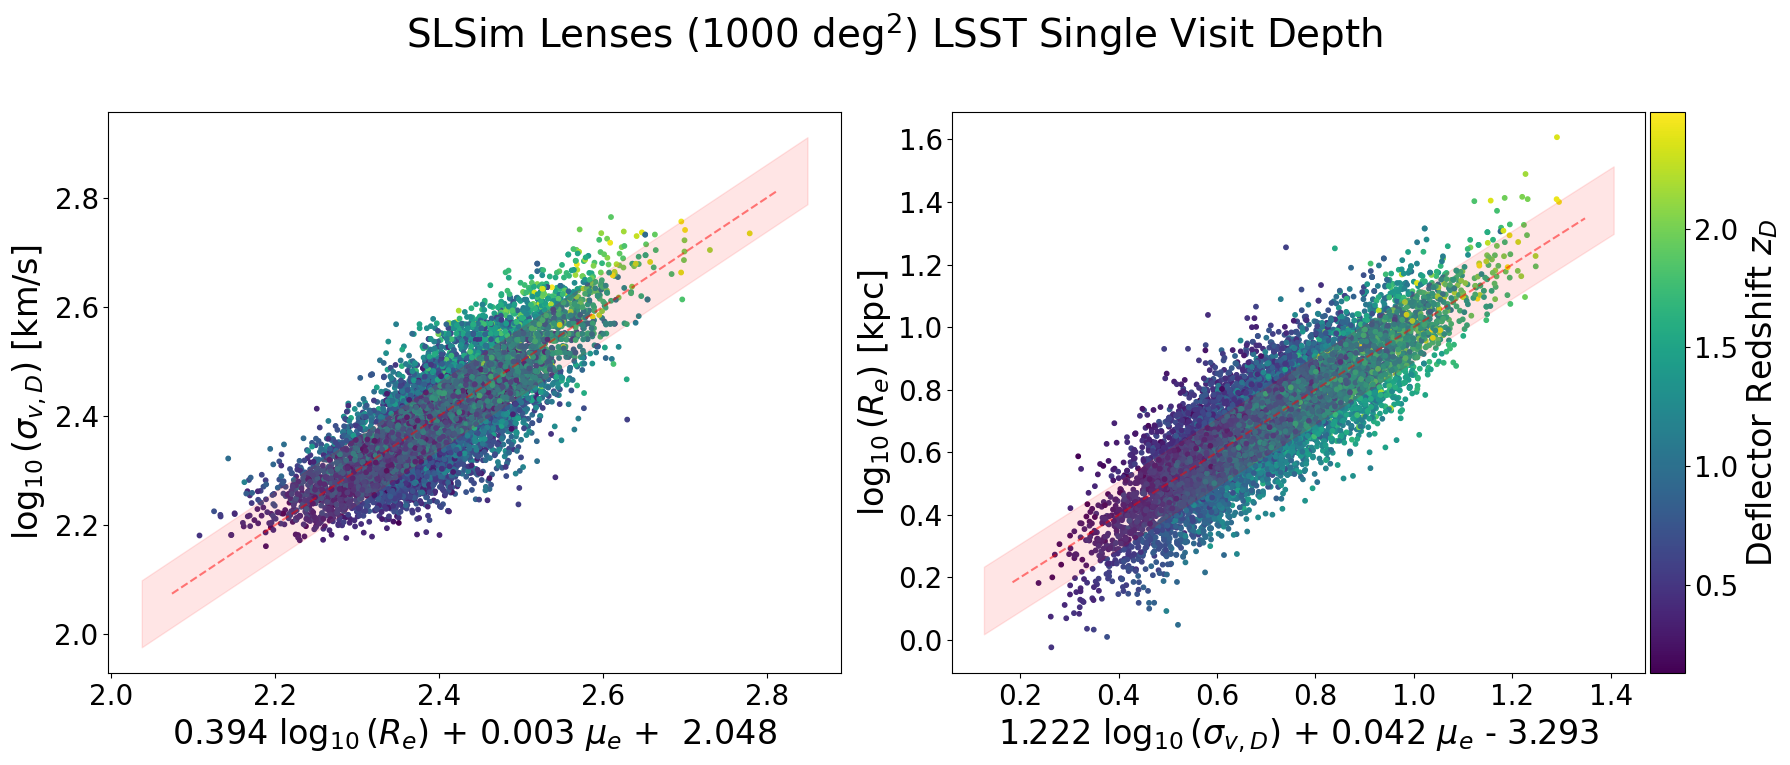

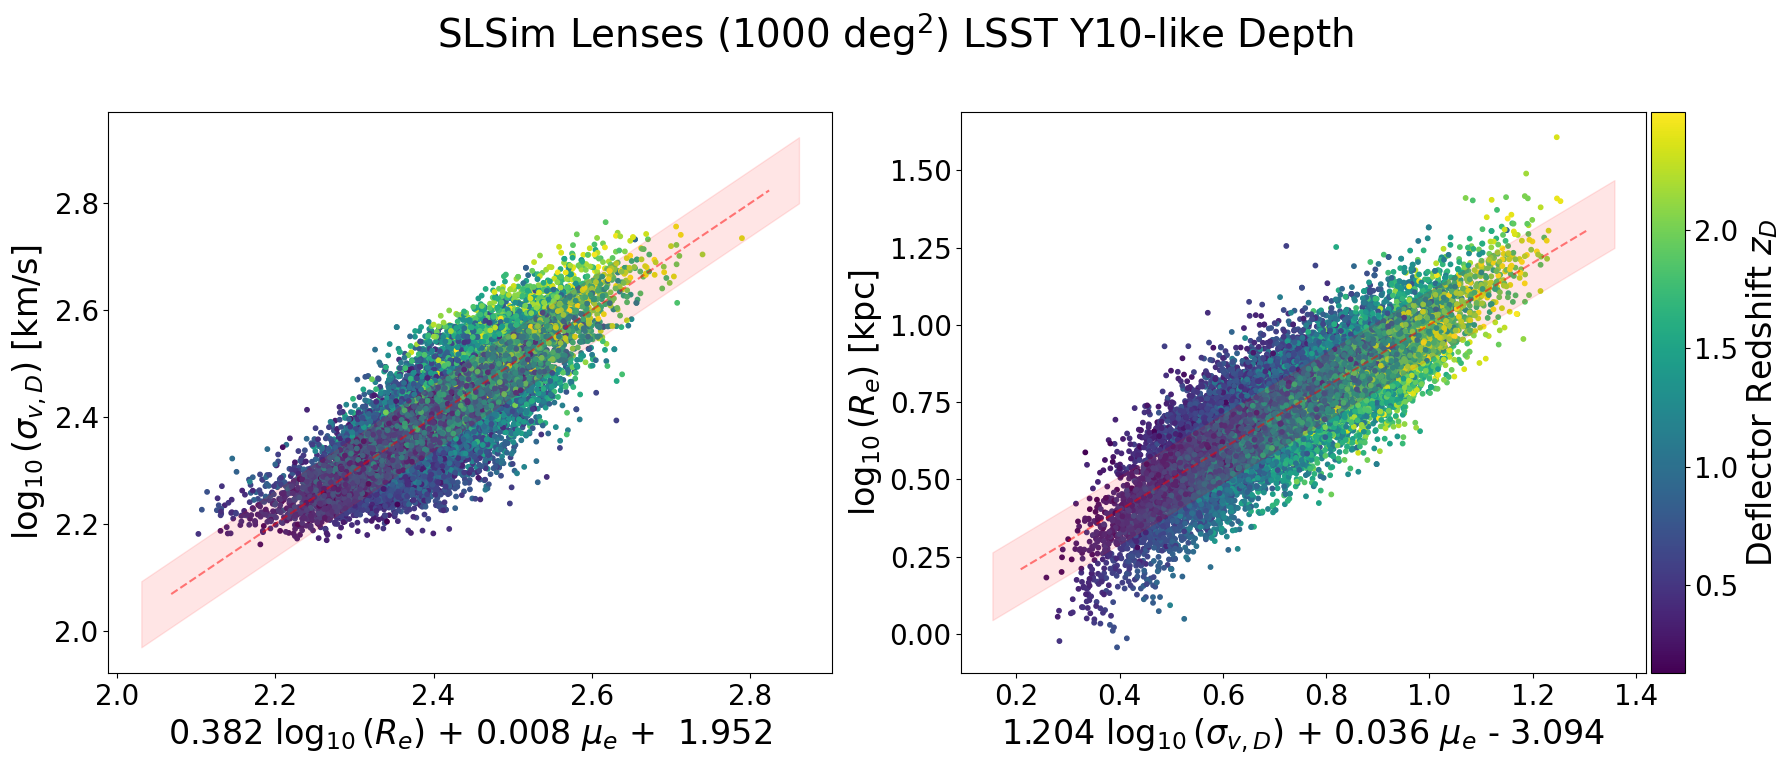

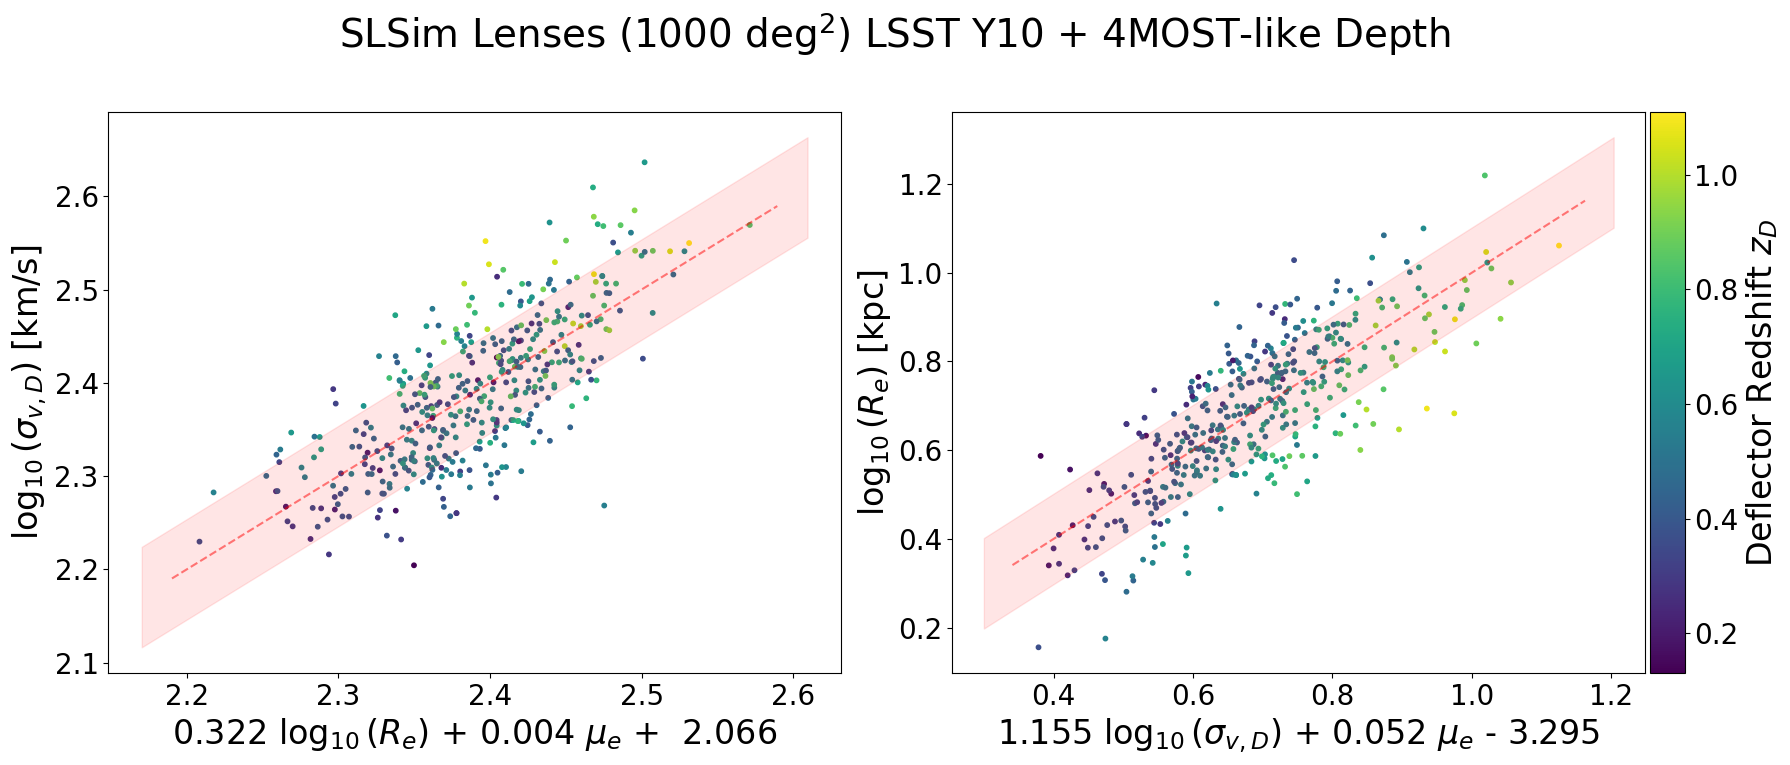

In [6]:
# MFP for the original data at different depths

# title_list = [
#     "SLSim Lenses (1000 deg$^2$) Y1-like Depth",
#     "SLSim Lenses (1000 deg$^2$) Y10-like Depth",
#     "SLSim Lenses (1000 deg$^2$) 4MOST-like Depth",
# ]
title_list = [
    "SLSim Lenses (1000 deg$^2$) LSST Single Visit Depth",
    "SLSim Lenses (1000 deg$^2$) LSST Y10-like Depth",
    "SLSim Lenses (1000 deg$^2$) LSST Y10 + 4MOST-like Depth",
]
i = 0
for data_table in [GGL_data_table[lsst_1_yr_coadd_mag_depth_mask],
                   GGL_data_table[lsst_10_yr_coadd_mag_depth_mask],
                   GGL_data_table[lsst_4MOST_mag_depth_mask]]:
    # fit the MFP
    coeffs_MFP = fit_plane(
        np.log10(data_table["R_e_kpc"]),
        data_table["surf_bri_mag/arcsec2"],
        np.log10(data_table["sigma_v_D"])
    )

    # find the scatter
    scatter_MFP = find_scatter(
        np.log10(data_table["R_e_kpc"]),
        data_table["surf_bri_mag/arcsec2"],
        np.log10(data_table["sigma_v_D"]),
        coeffs_MFP,
        return_fit=False
    )

    # fit the MFP with R_e as the dependent variable
    coeffs_MFP_alt = fit_plane(
        np.log10(data_table["sigma_v_D"]),
        data_table["surf_bri_mag/arcsec2"],
        np.log10(data_table["R_e_kpc"])
    )

    # find the scatter
    scatter_MFP_alt = find_scatter(
        np.log10(data_table["sigma_v_D"]),
        data_table["surf_bri_mag/arcsec2"],
        np.log10(data_table["R_e_kpc"]),
        coeffs_MFP_alt,
        return_fit=False
    )

    # print the scatter in percentage
    print(title_list[i], "sigma_v scatter (MFP):", np.round(np.std(scatter_MFP) * np.log(10) * 100, 2), "%")
    # print(title_list[i], "scatter (MFP alt):", np.std(scatter_MFP_alt) * np.log(10) * 100, "%")

    # side-by-side plot of the two fundamental planes
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # sigma_v fundamental plane
    axs[0].scatter(
        coeffs_MFP[0] * np.log10(data_table["R_e_kpc"]) + 
        coeffs_MFP[1] * data_table["surf_bri_mag/arcsec2"] + 
        coeffs_MFP[2],
        np.log10(data_table["sigma_v_D"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[0].set_xlabel(f'{coeffs_MFP[0]:.3f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_MFP[1]:.3f} ' + r'$\mu_e$ + ' + f' {coeffs_MFP[2]:.3f}')
    axs[0].set_ylabel(r'$\log_{10}(\sigma_{v, D})$ [km/s]')
    # axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

    # Plot the fitted plane with a faded scatter
    # y = x
    axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
    y_faded = x_faded
    axs[0].fill_between(x_faded, y_faded - np.std(scatter_MFP),
                        y_faded + np.std(scatter_MFP), color='red', alpha=0.1)

    # R_e fundamental plane
    scatter_plot = axs[1].scatter(
        coeffs_MFP_alt[0] * np.log10(data_table["sigma_v_D"]) + 
        coeffs_MFP_alt[1] * data_table["surf_bri_mag/arcsec2"] + 
        coeffs_MFP_alt[2],
        np.log10(data_table["R_e_kpc"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[1].set_xlabel(f'{coeffs_MFP_alt[0]:.3f} ' + r'$\log_{10}(\sigma_{v, D})$ ' + f'{'+' if coeffs_MFP_alt[1] > 0 else '-'} {np.abs(coeffs_MFP_alt[1]):.3f} ' + r'$\mu_e$ ' + f'{'+' if coeffs_MFP_alt[2] > 0 else '-'} {np.abs(coeffs_MFP_alt[2]):.3f}')
    axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
    # axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
    # Plot the fitted plane with a faded scatter
    # y = x
    axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
    y_faded = x_faded
    axs[1].fill_between(x_faded, y_faded - np.std(scatter_MFP_alt),
                        y_faded + np.std(scatter_MFP_alt), color='red', alpha=0.1)

    # common colorbar
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scatter_plot, cax=cax)
    cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


    # increase the font size of the labels and title
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xlabel(ax.get_xlabel(), fontsize=24)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24)
        ax.set_title(ax.get_title(), fontsize=24)
        # ax.legend(fontsize=14)

    # cbar label size
    cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=24)

    # cbar tick labels
    cbar.ax.tick_params(labelsize=20)

    # axs[0].set_xlim(2.13, 2.6)
    # axs[0].set_ylim(2.13, 2.6)
    # axs[1].set_xlim(0.2, 1.3)
    # axs[1].set_ylim(0.2, 1.3)

    fig.suptitle(title_list[i], fontsize=28)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    i += 1

# save the figure
# fig.savefig(f"../figures/slsim_MFP.pdf", bbox_inches='tight', dpi=300)

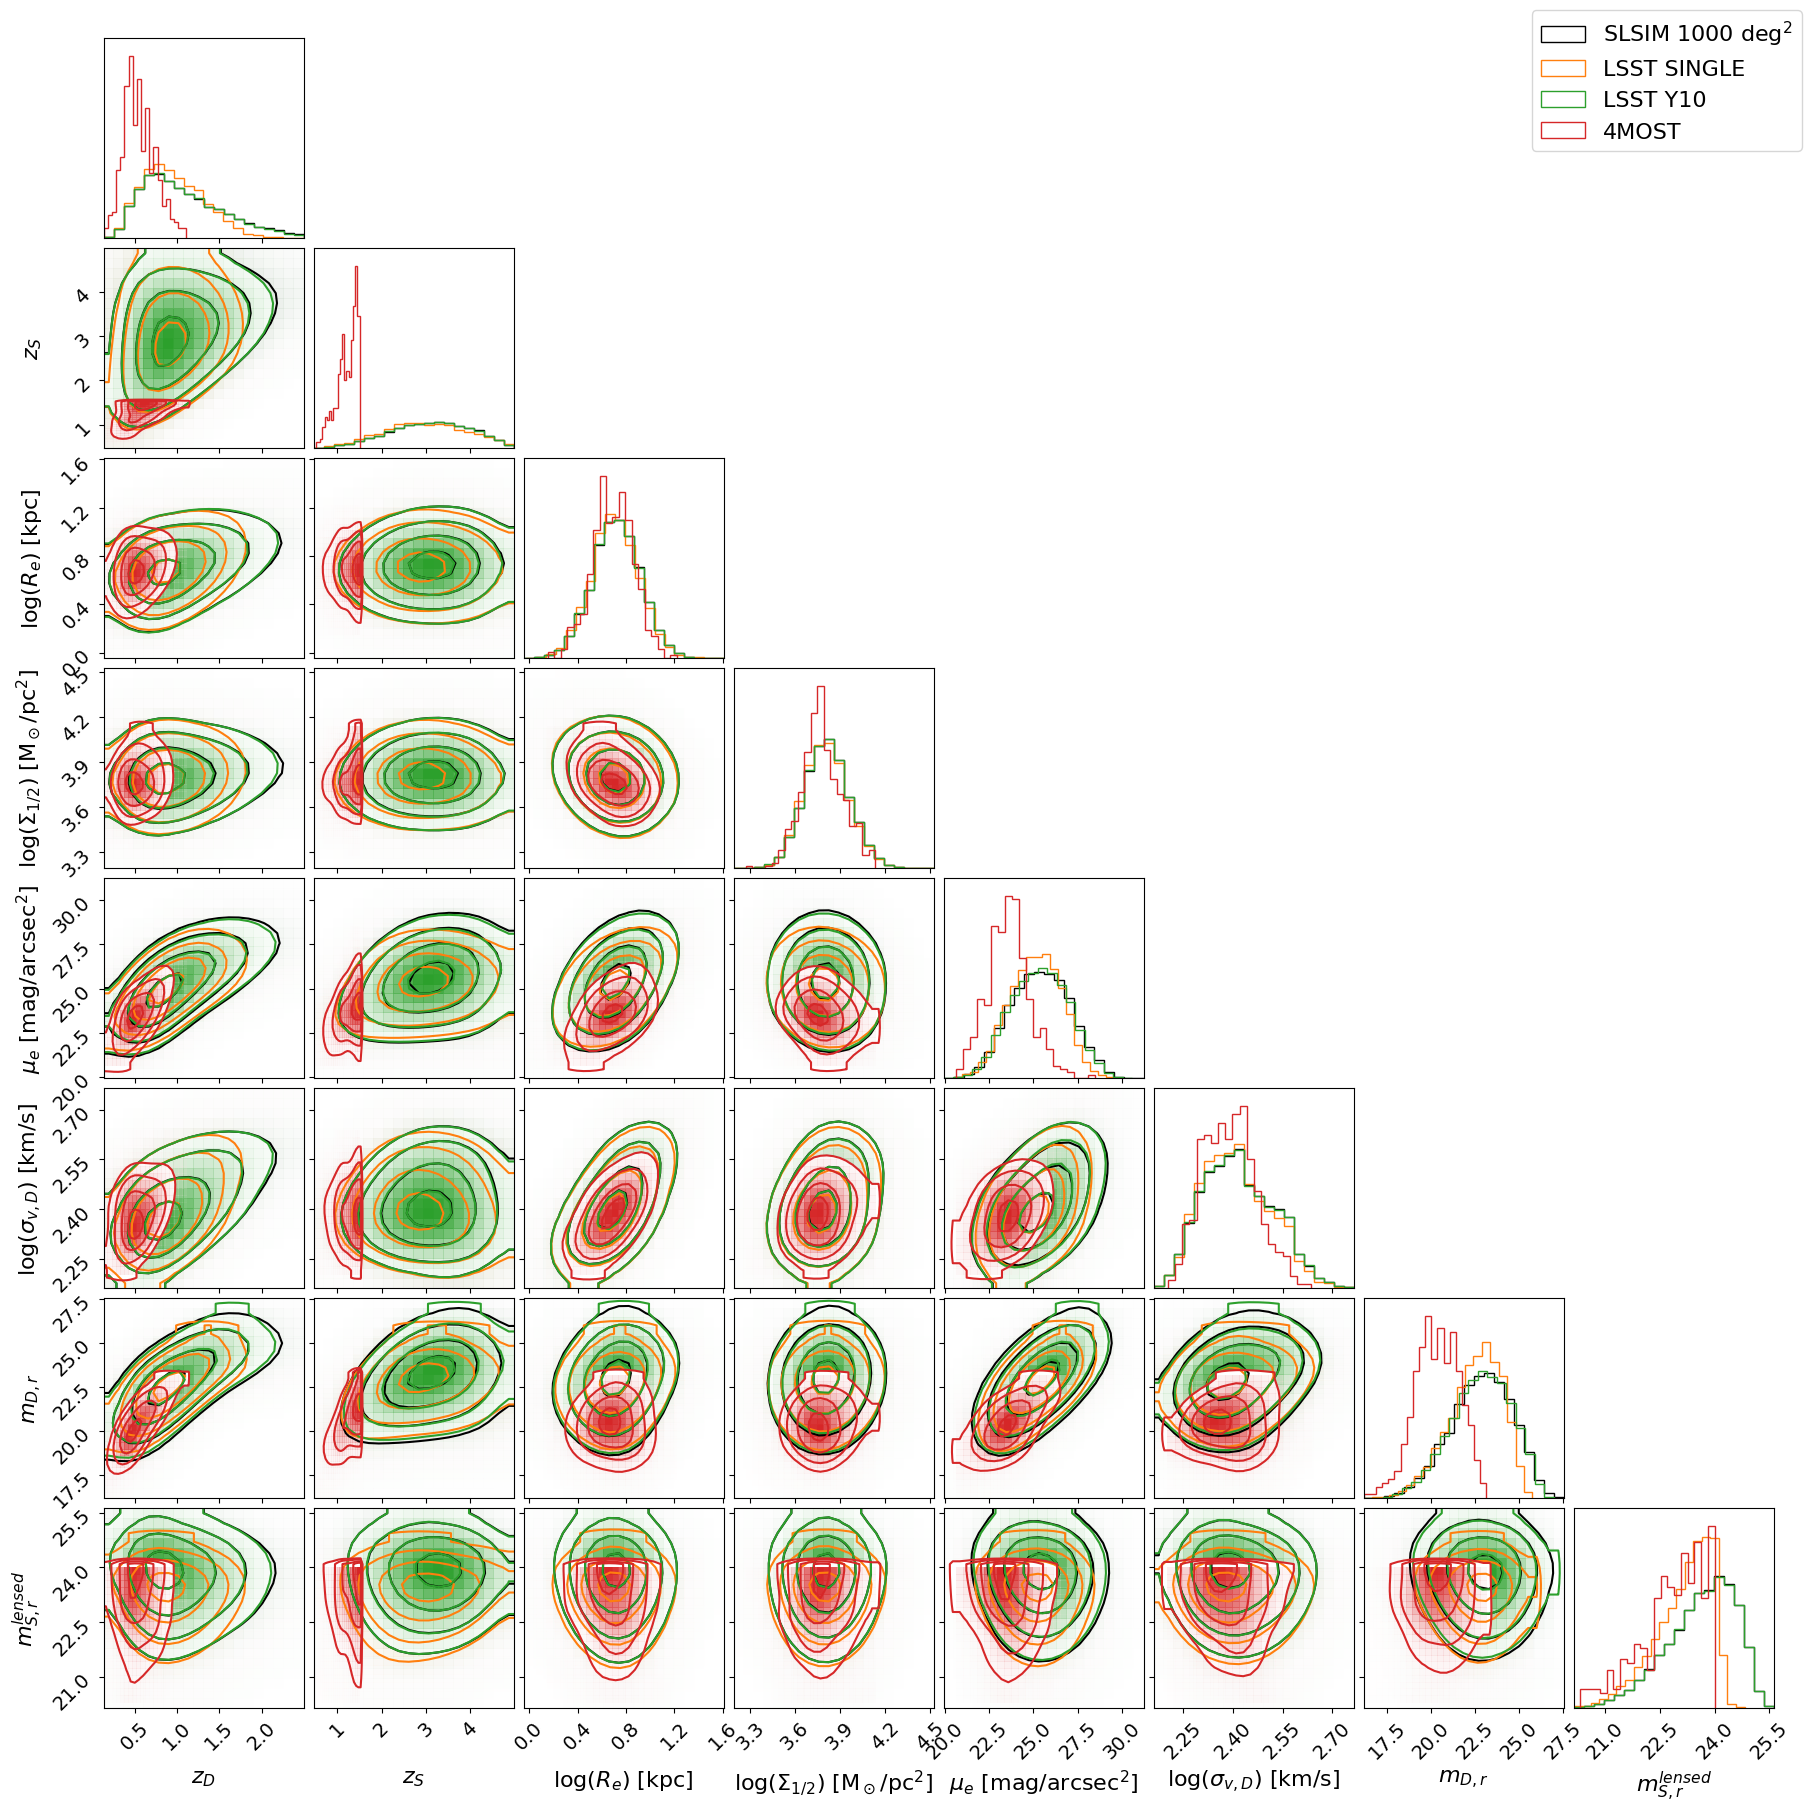

In [11]:
#### Make corner plot of the Original and 3 depth cut data sets
key_list = ['z_D',
            'z_S',
            'log_R_e_kpc', 
            'log_Sigma_half_Msun/pc2', 
            'surf_bri_mag/arcsec2',
            'log_sigma_v_D', 
            'mag_D_r', 
            'mag_S_r_lensed']
key_latex_labels = {
    'z_D': r'$z_D$',
    'z_S': r'$z_S$',
    'log_R_e_kpc': r'$\log(R_e)$ [kpc]',
    'log_Sigma_half_Msun/pc2': r'$\log(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]',
    'surf_bri_mag/arcsec2': r'$\mu_e$ [mag/arcsec$^2$]',
    'log_sigma_v_D': r'$\log(\sigma_{v, D})$ [km/s]',
    'mag_D_r': r'$m_{D, r}$',
    'mag_S_r': r'$m_{S, r}$',
    'mag_S_r_lensed': r'$m_{S, r}^{lensed}$'
}

GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

data_corner = [GGL_data_table[key] for key in key_list]
data_corner = np.array(data_corner).T

data_corner_Y1 = [GGL_data_table[lsst_1_yr_coadd_mag_depth_mask][key] for key in key_list]
data_corner_Y1 = np.array(data_corner_Y1).T

data_corner_Y10 = [GGL_data_table[lsst_10_yr_coadd_mag_depth_mask][key] for key in key_list]
data_corner_Y10 = np.array(data_corner_Y10).T

data_corner_4MOST = [GGL_data_table[lsst_4MOST_mag_depth_mask][key] for key in key_list]
data_corner_4MOST = np.array(data_corner_4MOST).T

fig_corner = corner.corner(
    data_corner,
    labels=[key_latex_labels[key] for key in key_list],
    hist_kwargs={"density": True},
    # show_titles=True,
    smooth=2,
    # smooth1d=True,
    plot_datapoints=False,
);

corner.corner(
    data_corner_Y1,
    labels=[key_latex_labels[key] for key in key_list],
    hist_kwargs={"density": True},
    color='C1',
    smooth=2,
    fig=fig_corner,
    plot_datapoints=False,
);

corner.corner(
    data_corner_Y10,
    labels=[key_latex_labels[key] for key in key_list],
    hist_kwargs={"density": True},
    color='C2',
    smooth = 2,
    fig=fig_corner,
    plot_datapoints=False,
);

corner.corner(
    data_corner_4MOST,
    labels=[key_latex_labels[key] for key in key_list],
    hist_kwargs={"density": True},
    color='C3',
    smooth = 2,
    fig=fig_corner,
    plot_datapoints=False,
);

fig_corner.legend(
    ['SLSIM 1000 deg$^2$', 'LSST SINGLE', 'LSST Y10', '4MOST'],
    loc='upper right',
    fontsize=16
)

# make the font size of the labels and titles larger
for ax in fig_corner.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=16)

# save the figure
# fig_corner.savefig(f"../figures/slsim_corner_GGL.pdf", bbox_inches='tight', dpi=300)

In [12]:
GGL_data_table

<Table length=15987>
lens_id        z_D         ... log_Sigma_half_Msun/pc2   log_sigma_v_D   
 int64       float64       ...         float64              float64      
------- ------------------ ... ----------------------- ------------------
      0 1.4100545160514653 ...      3.8872840619585918  2.508103323847279
      1  1.512036472199786 ...      3.7399493175238785  2.442159831222634
      3 1.3797860102766537 ...      3.8538004925364007 2.5252553258382404
      4 0.9793203674576667 ...       3.695661335045877   2.49636698295549
      5 0.6815442845076662 ...      3.5333844215715136  2.397918889636897
      6 1.5257562380230418 ...       3.630929127360413 2.3837096939200952
      8 1.0324273124661707 ...      3.8367280889901223 2.5627536799785386
      9 0.7954816615230628 ...        3.87267777198998 2.5235348106369155
     10 1.0777004207741332 ...       3.823233308971926  2.387583852357524
    ...                ... ...                     ...                ...
  29694 0.7973260127575952 ...        4.03616840388116  2.292985808527253
  29695 1.3937259888490465 ...       3.983897930087381  2.484161384577966
  29697  0.403028235790644 ...       3.940774208981249 2.3198769402321884
  29698 0.6345534618124111 ...      3.9543053604027443   2.47216803893931
  29699 0.6265117135448391 ...      3.6124573477982285  2.288474973455177
  29700  0.698650082467901 ...      3.7723723774589852 2.2316371620395876
  29701 1.6830574101127422 ...      3.7950235892906257 2.5723495705875306
  29703 0.8330528734245778 ...       3.987122377151558 2.3432842894946977
  29704 1.1176306371706077 ...      3.6564871857816006 2.4049475912145897
  29705 1.0313899705078013 ...      3.8903569619877327  2.415942407850453

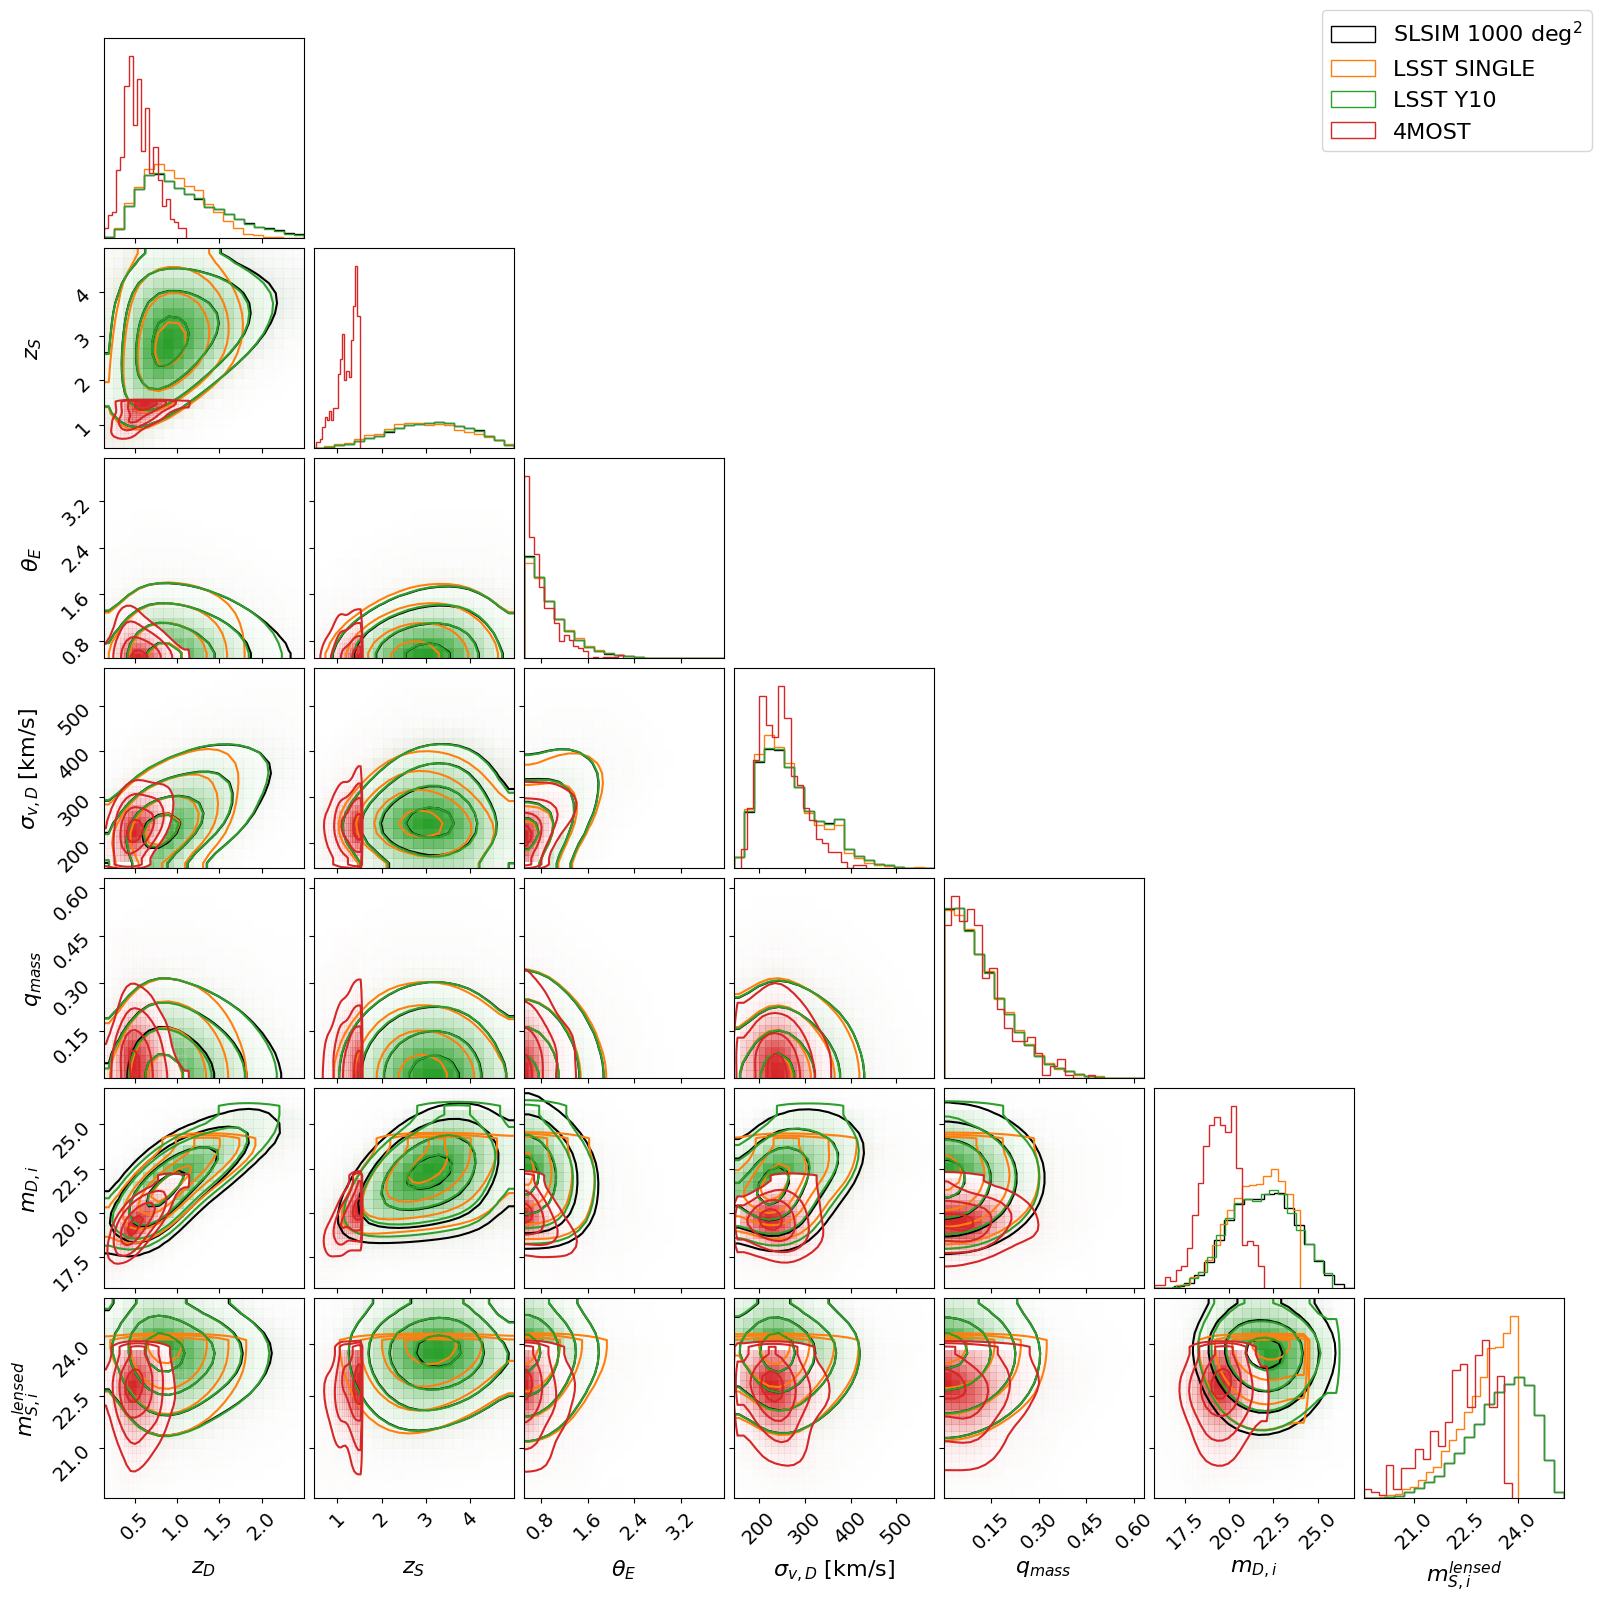

In [16]:
#### Make corner plot of the Original and 3 depth cut data sets
key_list = ['z_D',
            'z_S',
            'theta_E',
            'sigma_v_D',
            'e_mass_D',
            'mag_D_i',
            # 'mag_S_r',
            'mag_S_i_lensed'
            ]
key_latex_labels = {
    'z_D': r'$z_D$',
    'z_S': r'$z_S$',
    'theta_E': r'$\theta_E$',
    'sigma_v_D': r'$\sigma_{v, D}$ [km/s]',
    'e_mass_D': r'$q_{mass}$',
    'mag_D_i': r'$m_{D, i}$',
    'mag_S_i': r'$m_{S, i}$',
    'mag_S_i_lensed': r'$m_{S, i}^{lensed}$'
}

GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

data_corner = [GGL_data_table[key] for key in key_list]
data_corner = np.array(data_corner).T

data_corner_Y1 = [GGL_data_table[lsst_1_yr_coadd_mag_depth_mask][key] for key in key_list]
data_corner_Y1 = np.array(data_corner_Y1).T

data_corner_Y10 = [GGL_data_table[lsst_10_yr_coadd_mag_depth_mask][key] for key in key_list]
data_corner_Y10 = np.array(data_corner_Y10).T

data_corner_4MOST = [GGL_data_table[lsst_4MOST_mag_depth_mask][key] for key in key_list]
data_corner_4MOST = np.array(data_corner_4MOST).T

fig_corner = corner.corner(
    data_corner,
    labels=[key_latex_labels[key] for key in key_list],
    hist_kwargs={"density": True},
    # show_titles=True,
    smooth=2,
    # smooth1d=True,
    plot_datapoints=False,
);

corner.corner(
    data_corner_Y1,
    labels=[key_latex_labels[key] for key in key_list],
    hist_kwargs={"density": True},
    color='C1',
    smooth=2,
    fig=fig_corner,
    plot_datapoints=False,
);

corner.corner(
    data_corner_Y10,
    labels=[key_latex_labels[key] for key in key_list],
    hist_kwargs={"density": True},
    color='C2',
    smooth = 2,
    fig=fig_corner,
    plot_datapoints=False,
);

corner.corner(
    data_corner_4MOST,
    labels=[key_latex_labels[key] for key in key_list],
    hist_kwargs={"density": True},
    color='C3',
    smooth = 2,
    fig=fig_corner,
    plot_datapoints=False,
);

fig_corner.legend(
    ['SLSIM 1000 deg$^2$', 'LSST SINGLE', 'LSST Y10', '4MOST'],
    loc='upper right',
    fontsize=16
)

# make the font size of the labels and titles larger
for ax in fig_corner.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=16)

# save the figure
fig_corner.savefig(f"../figures/slsim_corner_GGL.pdf", bbox_inches='tight', dpi=300)

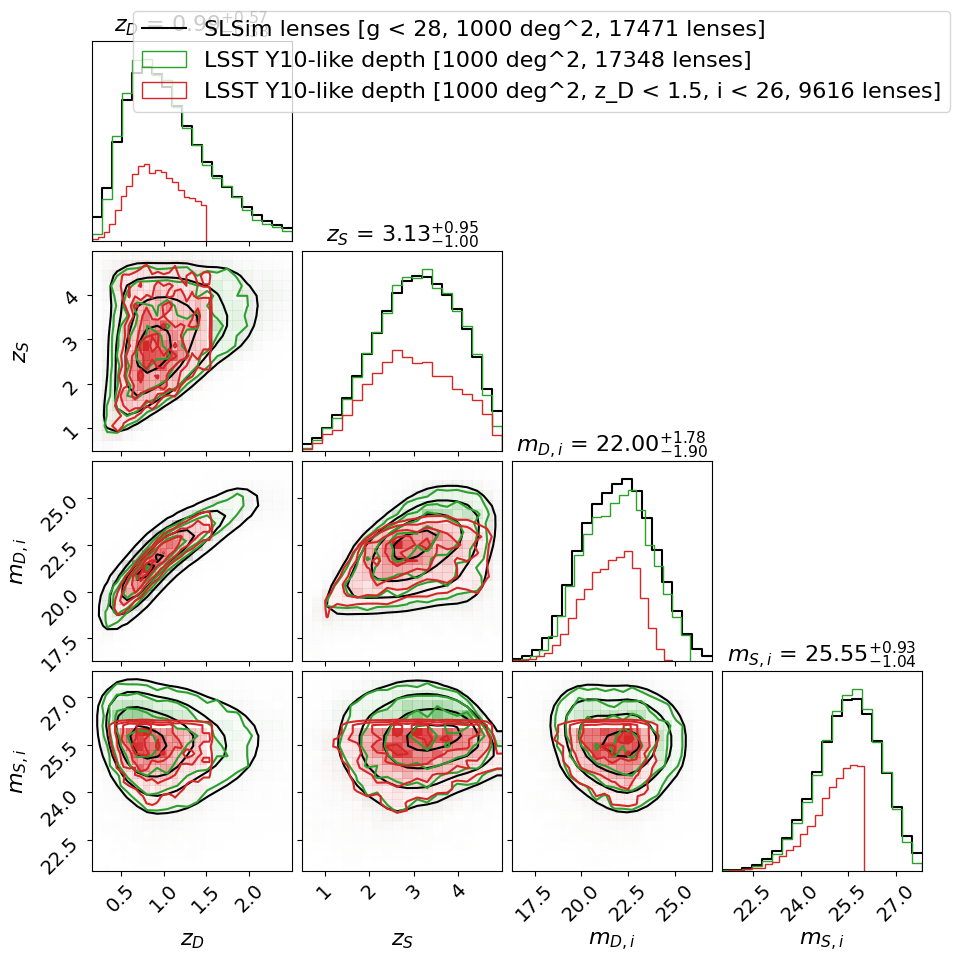

In [9]:
#### Make corner plot of the Original and 3 depth cut data sets
key_list = ['z_D',
            'z_S',
            # 'log_R_e_kpc', 
            # 'log_Sigma_half_Msun/pc2', 
            # 'log_sigma_v_D', 
            'mag_D_i', 
            'mag_S_i']
key_latex_labels = {
    'z_D': r'$z_D$',
    'z_S': r'$z_S$',
    # 'log_R_e_kpc': r'$\log_{10}(R_e)$ [kpc]',
    # 'log_Sigma_half_Msun/pc2': r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]',
    # 'log_sigma_v_D': r'$\log_{10}(\sigma_{v, D})$ [km/s]',
    'mag_D_i': r'$m_{D, i}$',
    'mag_S_i': r'$m_{S, i}$'
}

GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

data_corner = [GGL_data_table[key] for key in key_list]
data_corner = np.array(data_corner).T

# data_corner_Y1 = [GGL_data_table[lsst_1_yr_coadd_mag_depth_mask][key] for key in key_list]
# data_corner_Y1 = np.array(data_corner_Y1).T

data_corner_Y10 = [GGL_data_table[lsst_10_yr_coadd_mag_depth_mask][key] for key in key_list]
data_corner_Y10 = np.array(data_corner_Y10).T

lsst_10_yr_coadd_mag_depth_mask_v2 = (GGL_data_table['z_D'] < 1.5) & (GGL_data_table['mag_D_i'] < 26) & (GGL_data_table['mag_S_i'] < 26.0)
data_corner_Y10_v2 = [GGL_data_table[lsst_10_yr_coadd_mag_depth_mask_v2][key] for key in key_list]
data_corner_Y10_v2 = np.array(data_corner_Y10_v2).T

# data_corner_4MOST = [GGL_data_table[lsst_4MOST_mag_depth_mask][key] for key in key_list]
# data_corner_4MOST = np.array(data_corner_4MOST).T

fig_corner = corner.corner(
    data_corner,
    labels=[key_latex_labels[key] for key in key_list],
    show_titles=True,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
);

# corner.corner(
#     data_corner_Y1,
#     labels=[key_latex_labels[key] for key in key_list],
#     color='C1',
#     fig=fig_corner,
#     plot_datapoints=False,
# );

corner.corner(
    data_corner_Y10,
    labels=[key_latex_labels[key] for key in key_list],
    color='C2',
    fig=fig_corner,
    plot_datapoints=False,
);

corner.corner(
    data_corner_Y10_v2,
    labels=[key_latex_labels[key] for key in key_list],
    color='C3',
    fig=fig_corner,
    plot_datapoints=False,
);

fig_corner.legend(
    [f'SLSim lenses [g < 28, 1000 deg^2, {len(data_corner)} lenses]', f'LSST Y10-like depth [1000 deg^2, {len(data_corner_Y10)} lenses]', f'LSST Y10-like depth [1000 deg^2, z_D < 1.5, i < 26, {len(data_corner_Y10_v2)} lenses]'],
    loc='upper right',
    fontsize=16
)

# make the font size of the labels and titles larger
for ax in fig_corner.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=16)